In [3]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [5]:
data_dir='input'

for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    img = cv2.imread(image_path)
    extension = imghdr.what(image_path)
    if extension not in ['jpeg', 'jpg', 'png']:
      os.remove(image_path)

In [6]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
iterator = data.as_numpy_iterator()
batch = iterator.next()

Found 626 files belonging to 3 classes.


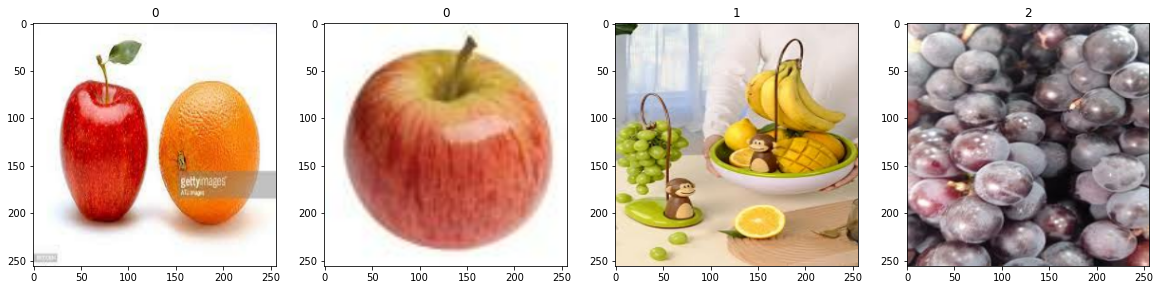

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) #show label

In [8]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)
data = data.map(lambda x,y: (x/255, y))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 626 files belonging to 3 classes.


In [9]:
data_iterator=data.as_numpy_iterator()

In [32]:
batch=data_iterator.next()

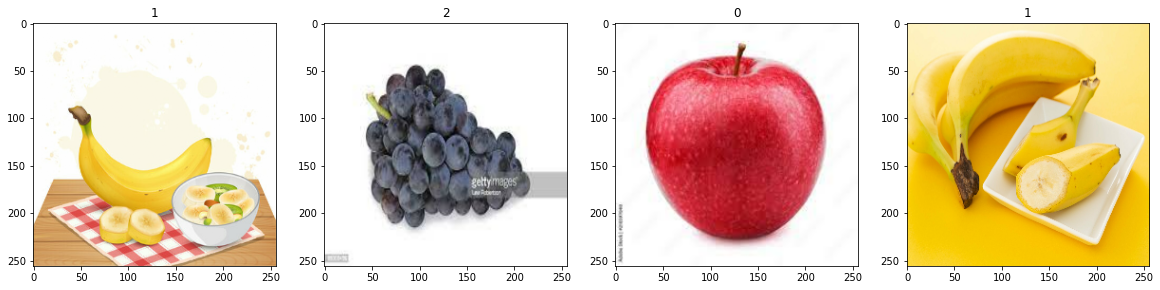

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx]) #show label

In [34]:
model = Sequential()

model.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(512, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 256)     147712    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 512)       1180160   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 512)      0

In [36]:
process = model.fit(train, epochs=100, validation_data=val)

Epoch 1/100
14/14 [==============================] - 17s 653ms/step - loss: 17.5752 - accuracy: 0.3616 - val_loss: 1.0388 - val_accuracy: 0.4922
Epoch 2/100
14/14 [==============================] - 10s 645ms/step - loss: 1.0137 - accuracy: 0.5156 - val_loss: 0.8901 - val_accuracy: 0.5781
Epoch 3/100
14/14 [==============================] - 10s 649ms/step - loss: 0.8250 - accuracy: 0.6339 - val_loss: 0.6041 - val_accuracy: 0.7578
Epoch 4/100
14/14 [==============================] - 10s 648ms/step - loss: 0.6228 - accuracy: 0.7411 - val_loss: 0.5616 - val_accuracy: 0.7812
Epoch 5/100
14/14 [==============================] - 10s 654ms/step - loss: 0.5797 - accuracy: 0.8058 - val_loss: 0.5070 - val_accuracy: 0.8203
Epoch 6/100
14/14 [==============================] - 10s 648ms/step - loss: 0.4667 - accuracy: 0.8259 - val_loss: 0.3037 - val_accuracy: 0.8906
Epoch 7/100
14/14 [==============================] - 10s 650ms/step - loss: 0.3507 - accuracy: 0.8438 - val_loss: 0.2649 - val_accuracy

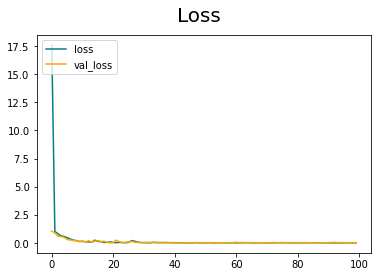

In [37]:
fig = plt.figure()
plt.plot(process.history['loss'], color='teal', label='loss')
plt.plot(process.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

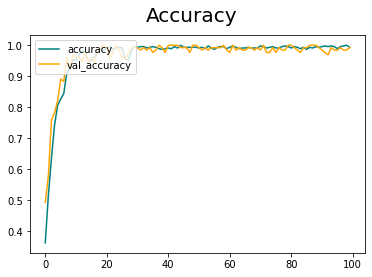

In [38]:
fig = plt.figure()
plt.plot(process.history['accuracy'], color='teal', label='accuracy')
plt.plot(process.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [41]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [42]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    pd_df = pd.get_dummies(y)
    oh=np.array(pd_df)
    yhat = model.predict(X)
    pre.update_state(oh, yhat)
    re.update_state(oh, yhat)
    acc.update_state(oh, yhat)

In [44]:
pre.result().numpy(), re.result().numpy(), acc.result().numpy()

(0.98, 0.98, 0.98)

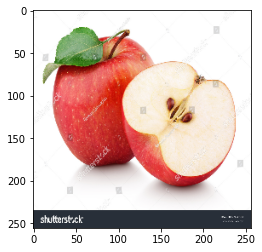

In [49]:
img = cv2.imread('/content/drive/MyDrive/ImageClassification/input/apple/-half-and-green-apple-leaf-isolated-on-white-background-apples-and-699645961.jpg')
img=cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [48]:
predIndex = np.argmax(yhat)
if predIndex == 0: 
  print(f'Apple')
elif predIndex == 1:
  print(f'Banana')
else:
  print(f'Grape')

Apple
